# CS4243 Lab 4: Tracking

In [6]:
# Setup
%matplotlib inline
%load_ext autoreload
%autoreload 1

import cv2
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import HTML
from skimage import filters
from skimage.feature import corner_harris, corner_peaks

%aimport lab4
from lab4 import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Introduction

In this lab assignment, your task is to implement the "mean_shift" and "Lucas-Kanad optical flow" tracking algorithms for the video tracking task.

Implement all operations in `lab4.py` file.


References:
* Lecture 11, Lecture 12.
* lab4.pdf.

### Instructions
This Jupiter notebook provides the basic facilities for running your code and visualization of the results. You are required to **finish the implementations in accompanying python file (`lab4.py`).**

You should also **adjust the parameters** in the identified positions to obtain the desired results.


Please note the following:
1. Detailed instructions are provided in the pdf file **( lab4.pdf )**, you should refer to it for more instructions.
2. The parts you need to implement are marked with the following:

    ```
    """ YOUR CODE STARTS HERE """

    """ YOUR CODE ENDS HERE """
    ```
    
    
You should only write your code in between the above two lines. Do not change the existing functions, e.g., rename the function or delete some functions.
    
3. Adjust the parameters at the locations with the following marks::

    ```
    """ PARAMETERS HERE """

    """ PARAMETERS HERE """
    ```
    
    
5. For each part, there may be some prohibited functions. **DO NOT use those prohibited functions**. If you are not sure, please ask TA for help.


# Part 1. Mean Shift Tracking


#### 1.0 Video Visualization
The video is provided as a time series of images. We have provided you with utility functions to load image frames and visualize them as short video clips. 

In [7]:
# load frames
path = "BlurBody/img/"
frames = load_frames_rgb(path)

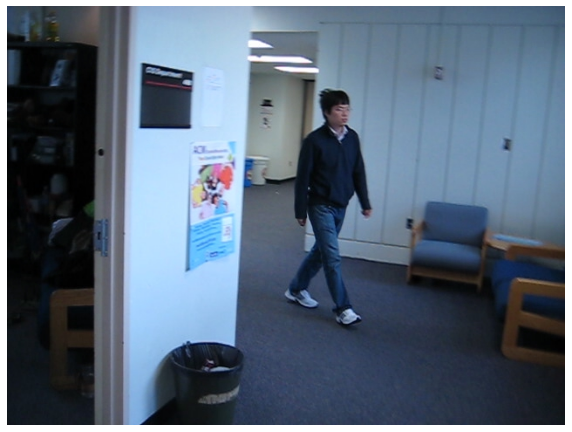

In [8]:
# video visualization
ani = animated_frames(frames)
HTML(ani.to_html5_video())

#### 1.1 Histogram Computation
Unlike lab2, the image spatial density of the pixel grid is uniform here. Therefore, we need to weight the pixels based on the histogram similarity between the pixels and the target. In order to obtain the histogram, we will first convert the RGB to HSV color space, and then calculate the target histogram given the initial ROI (Region of Interest). You need to select the cutoff value of the histogram threshold and the channel used for the back projection calculation to get good results in the next few parts.

* **Please adjust the parameters about histogram here to get better performance (IoU).** 

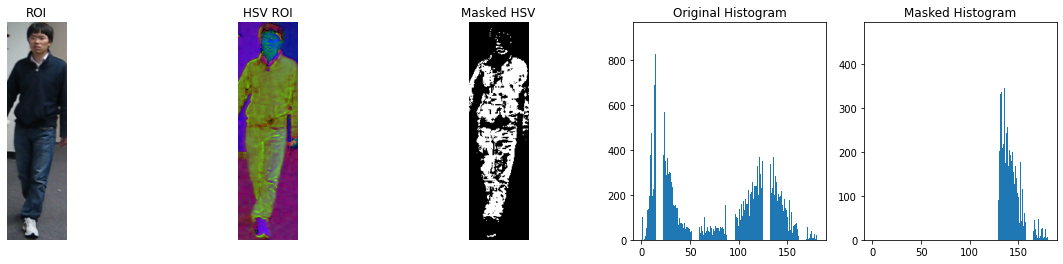

In [128]:
plt.rcParams['figure.figsize'] = (20, 4) 

# first frame in the video
frame1 = frames[0]

# windows position for human body in frame 1.
x, y, w, h = 400,48,87,319 
track_window = (x,y,w,h)
# get region of interest in the frame
roi = frame1[y:y+h,x:x+w]
# convert to hsv color space
hsv_roi = cv2.cvtColor(roi,cv2.COLOR_RGB2HSV)


""" PARAMETERS HERE """
# Histogram masking parameters.
thresh_value1 = 120.
thresh_value2 = 20.
# index of channel for which we calculate Histogram.
# 0:hue, 1:saturation, 2:lightness
channel = 1
""" PARAMETERS HERE """


mask = cv2.inRange(hsv_roi,np.array((0.,thresh_value1,thresh_value2,)),np.array((180.,255.,255.,))) 
roi_hist = cv2.calcHist([hsv_roi],[channel],mask,[180],[0,180])
roi_hist_nomask = cv2.calcHist([hsv_roi],[channel],None,[180],[0,180])


plt.subplot(1,5,1)
plt.imshow(roi)
plt.axis('off')
plt.title('ROI')

plt.subplot(1,5,2)
plt.imshow(hsv_roi)
plt.axis('off')
plt.title('HSV ROI')

plt.subplot(1,5,3)
plt.imshow(mask)
plt.axis('off')
plt.title('Masked HSV')

plt.subplot(1,5,4)
y1 = np.squeeze(roi_hist_nomask)
y1 =list(y1)
x1 = list(range(1,181,1))
plt.title("Original Histogram")
plt.bar(x1,y1)

plt.subplot(1,5,5)
y1 = np.squeeze(roi_hist)
y1 =list(y1)
x1 = list(range(1,181,1))
plt.title("Masked Histogram")
plt.bar(x1,y1)
plt.show()

#### 1.1 Histogram Backprojection 

Back projection is a way of recording how well the pixels of a given image fit the distributionof pixels in a histogram model. The value in the "dst" array represents the probability that the pixel belongs to the body region.

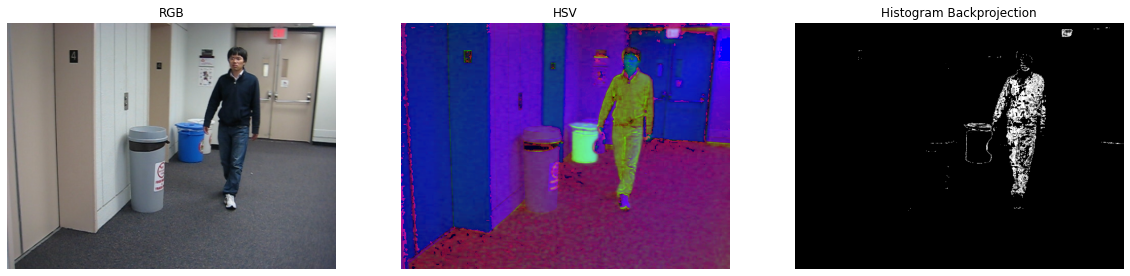

In [129]:
hsv_frame1 = cv2.cvtColor(frame1,cv2.COLOR_RGB2HSV)
dst = cv2.calcBackProject([hsv_frame1],[channel],roi_hist,[0,180],1)

plt.rcParams['figure.figsize'] = (20, 10)
plt.rcParams['image.cmap'] = 'gray'

plt.subplot(1,3,1)
plt.imshow(frame1)
plt.axis('off')
plt.title('RGB')

plt.subplot(1,3,2)
plt.imshow(hsv_frame1)
plt.axis('off')
plt.title('HSV')


plt.subplot(1,3,3)
plt.imshow(dst)
plt.axis('off')
plt.title('Histogram Backprojection')
plt.show()


#### 1.2 Mean Shift for Tracking

Now you can perform the mean shift algorithm on weighted pixels. What you need to do is to update iteratively on the tracking window as in lab2. The only difference is that we are now dealing with rectangles, so please pay attention to the situation when the window hits the image boundary.

* **Implement following function in `lab4.py`**: `meanShift()`   
* **Prohibited function**: `cv2.meanShift()`

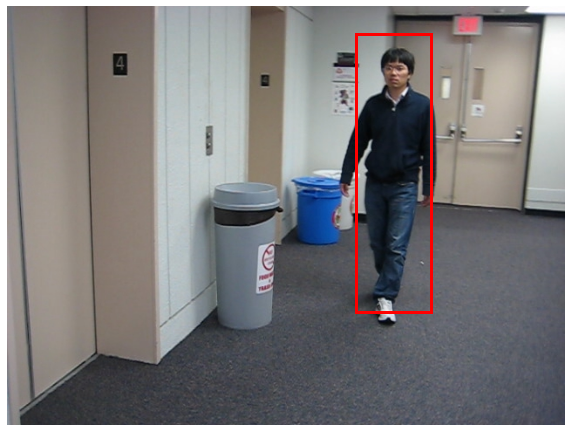

In [134]:
# Initailze bounding box
bboxes = []

# tracking windows position for human body in frame 1.
x, y, w, h = 400,48,87,319

# set to lower number for quick preview
frame_count = len(frames)
track_window = (x,y,w,h)
dsts = []

for frame in frames[:frame_count]:
    hsv = cv2.cvtColor(frame,cv2.COLOR_RGB2HSV)
    dst = cv2.calcBackProject([hsv],[channel],roi_hist,[0,180],1)
    dsts.append(dst)
    c = np.reshape(dst,(-1,1))
    
    # apply meanshift to get the optimal tracking window location(mode)
    track_window = meanShift(dst,track_window,max_iter=10,stop_thresh=0.01)

    ## OpenCV "model" answer
#     term_crit = ( cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.01 )
#     ret, track_window = cv2.meanShift(dst,track_window,term_crit)
    x,y,w,h = track_window
    bboxes.append((x,y,w,h))

ani = animated_bbox(frames[:frame_count], bboxes[:frame_count])
# show the backprojections instead of raw video
# ani = animated_bbox(dsts[:frame_count], bboxes[:frame_count])
# HTML(ani.to_html5_video())

#### 1.3 Evaluation: Intersection Over Union (IoU)


Intersection over union is a common metric for evaluating performance of an object tracker. Implement this metric to evaluate our object tracker. When the IoU score is higher than 0.65, you will get full marks.

* **Implement following function in `lab4.py`**: `IoU()`   

In [135]:
#load the graound_truth 
ground_path = "BlurBody/groundtruth_rect.txt"
f = open(ground_path)
gt_bboxes = []
ground_truth = f.readlines()
for i in range(len(ground_truth)):
    x = int(ground_truth[i].split()[0])
    y = int(ground_truth[i].split()[1])
    w = int(ground_truth[i].split()[2])
    h = int(ground_truth[i].split()[3])
    gt_bboxes.append((x,y,w,h))
    
#calculate the IOU
average_iou = 0.0
for gt_bbox, bbox in zip(gt_bboxes, bboxes):
    average_iou += IoU(gt_bbox, bbox)
    
average_iou /= len(gt_bboxes)
print('IoU: {:.2f}'.format(average_iou))

IoU: 0.68


# Part 2. Lucas-Kanade Optical Flow for Video Tracking

The optical flow method is used to estimate the object motion between two consecutive image frames. For example, in the video below, the can of tea appears to be moving to the left. For our system to be able to understand that the can is moving to the left, it would be useful to find a way to add vectors to the can (known as **flow vectors**) which point to the left, thus describing its motion. 



### 2.0 Video Visualization

In [ ]:
# load frames
path = "TeaCan"
frames_rgb = load_frames_rgb(path)
frames = load_frames_as_float_gray(path)

In [ ]:
# video visualization
ani = animated_frames(frames_rgb)
HTML(ani.to_html5_video())

### 2.1 Vanilla Lucas Kanade Tracking
#### 2.1.1  Feature Detection

In order to use Lucas-Kanade method for feature tracking, we first need to find keypoints to track. Harris corner detector is commonly used to initialize the keypoints to track with Lucas-Kanade method. For this assignment, we will use [`skimage` implementation](http://scikit-image.org/docs/dev/auto_examples/features_detection/plot_corner.html) of Harris corner detector.

In [ ]:
# Detect keypoints to track in first frame
keypoints = corner_peaks(corner_harris(frames[0]),
                         exclude_border=5,
                         threshold_rel=0.01)

# Plot kepoints

plt.figure(figsize=(15,12))

plt.imshow(frames[0], cmap="gray")
plt.scatter(keypoints[:,1], keypoints[:,0],
            facecolors='none', edgecolors='r')
plt.axis('off')
plt.title('Detected Keypoints in the First Frame')
plt.show()

#### 2.1.2 Optical Flow Computation

After detecting the "good" points to be tracked, the next step is to calculate the optical flow of these points. Implement function **`lucas_kanade`** based on the materails in the instruction file and lecture slides and run the code cell below. You will be able to see small arrows pointing towards the directions where keypoints are moving.
* **Implement following function in `lab4.py`**: `lucas_kanade()`   

In [ ]:
# Lucas-Kanade method for optical flow
flow_vectors = lucas_kanade(frames[0], frames[1], keypoints, window_size=5)

# Plot flow vectors
plt.figure(figsize=(15,12))
plt.imshow(frames[0], cmap="gray")
plt.axis('off')
plt.title('Optical Flow Vectors')

for y, x, vy, vx in np.hstack((keypoints, flow_vectors)):
    plt.arrow(x, y, vx, vy, head_width=3, head_length=3, color='b')
    

#### 2.1.3 Feature Tracking
You can then estimate the position of the keypoints in the next frame by adding the flow vectors to the current keypoints.

In [ ]:
# Plot tracked kepoints
new_keypoints = keypoints + flow_vectors
plt.figure(figsize=(15,12))
plt.imshow(frames[1], cmap="gray")
plt.scatter(new_keypoints[:,1], new_keypoints[:,0],
            facecolors='none', edgecolors='r')
plt.axis('off')
plt.title('Tracked Keypoints in the Second Frame')
plt.show()

#### 2.1.4 Feature Tracking in Multiple Frames
Now you can use Lucas-Kanade method to track keypoints across multiple frames. The idea is simple: compute flow vectors at keypoints in $i$-th frame, and add the flow vectors to the points to keep track of the points in $i+1$-th frame. We have provided the function `track_features` for you. First, run the code cell below. You will notice that some of the points just drift away and are not tracked very well.

Instead of keeping these 'bad' tracks, we would want to somehow declare some points are 'lost' and just discard them. One simple way is to compare the patches around tracked points in two subsequent frames. If the patch around a point is NOT similar to the patch around the corresponding point in the next frame, then we declare the point to be lost. Here, we are going to use mean squared error between two normalized patches as the criterion for lost tracks. Implement **`compute_error`**, and re-run the code cell below. You will see many of the points disappearing in later frames.

* **Implement following function in `lab4.py`**: `compute_error()`  


In [ ]:
# Detect keypoints to track in the first frame
keypoints = corner_peaks(corner_harris(frames[0]),
                         exclude_border=5,
                         threshold_rel=0.01)

trajs = track_features(frames, keypoints,
                       error_thresh=1.5,
                       optflow_fn=lucas_kanade,
                       window_size=5)
ani = animated_scatter(frames,trajs)
HTML(ani.to_html5_video())

### 2.2. Pyramidal Lucas-Kanade Feature Tracker
In this section, we are going to implement a simpler version of the method described in ["Pyramidal Implementation of the Lucas Kanade Feature Tracker"](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.185.585&rep=rep1&type=pdf).

#### 2.2.1 Iterative Lucas-Kanade Method
One limitation of the naive Lucas-Kanade method is that it cannot track large motions between frames. You might have noticed that the resulting flow vectors (blue arrows) in the previous section are too small that the tracked keypoints are slightly off from where they should be. In order to address this problem, we can iteratively refine the estimated optical flow vectors. 

Implement `iterative_lucas_kanade` method and run the following code cells below. You should be able to see slightly longer arrows in the visualization.

* **Implement following function in `lab4.py`**: `iterative_lucas_kanade()`  

In [ ]:
# Run iterative Lucas-Kanade method
flow_vectors = iterative_lucas_kanade(frames[0], frames[1], keypoints)

# Plot flow vectors
plt.figure(figsize=(15,12))
plt.imshow(frames[0], cmap = "gray")
plt.axis('off')
plt.title('Optical flow vectors (iterative LK)')

for y, x, vy, vx in np.hstack((keypoints, flow_vectors)):
    plt.arrow(x, y, vx, vy, head_width=3, head_length=3, color='b')

In [ ]:
# Plot tracked kepoints
new_keypoints = keypoints + flow_vectors
plt.figure(figsize=(15,12))
plt.imshow(frames[1], cmap = "gray")
plt.scatter(new_keypoints[:,1], new_keypoints[:,0],
            facecolors='none', edgecolors='r')
plt.axis('off')
plt.title('Tracked keypoints in the second frame (iterative LK)')
plt.show()

In [ ]:
# Detect keypoints to track in the first frame
keypoints = corner_peaks(corner_harris(frames[0]),
                         exclude_border=5,
                         threshold_rel=0.01)

# Track keypoints using iterative Lucas-Kanade method
trajs = track_features(frames, keypoints,
                       error_thresh=1.5,
                       optflow_fn=iterative_lucas_kanade,
                       window_size=5)
ani = animated_scatter(frames,trajs)
#ani.save("images2_itera.mp4")
HTML(ani.to_html5_video())

#### 2.2.2 Coarse-to-Fine Optical Flow for Tracking
The iterative method still could not track larger motions. If we downscaled the images, larger displacements would become easier to track. On the otherhand, smaller motions would become more difficult to track as we lose details in the images. To address this problem, we can represent images in multi-scale, and compute flow vectors from coarse to fine scale.

Run the following code cell to visualize the image pyramid and run the following code cell below for visualization. You will see a better results than what you've got above.

In [ ]:
from skimage.transform import pyramid_gaussian

image = frames[0]

# pyramid_gaussian returns tuple of max_layer + 1 images in multiple scales
pyramid = tuple(pyramid_gaussian(image, max_layer=3, downscale=2))

rows, cols = image.shape
composite_image = np.zeros((rows, cols + cols // 2 + 1), dtype=np.double)
composite_image[:rows, :cols] = pyramid[0]

i_row = 0
for p in pyramid[1:]:
    n_rows, n_cols = p.shape
    composite_image[i_row:i_row + n_rows, cols:cols + n_cols] = p
    i_row += n_rows

# Display image pyramid
plt.figure(figsize=(15,12))
plt.imshow(composite_image)
plt.axis('off')
plt.show()

Implement `pyramid_lucas_kanade`:
* **Implement following function in `lab4.py`**: `pyramid_lucas_kanade()`  

In [ ]:
# Lucas-Kanade method for optical flow
flow_vectors = pyramid_lucas_kanade(frames[0], frames[1], keypoints)
# Plot flow vectors
plt.figure(figsize=(15,12))
plt.imshow(frames[0])
plt.axis('off')
plt.title('Optical flow vectors (pyramid LK)')

for y, x, vy, vx in np.hstack((keypoints, flow_vectors)):
    plt.arrow(x, y, vx, vy, head_width=3, head_length=3, color='b')

In [ ]:
# Plot tracked kepoints
new_keypoints = keypoints + flow_vectors
plt.figure(figsize=(15,12))
plt.imshow(frames[1])
plt.scatter(new_keypoints[:,1], new_keypoints[:,0],
            facecolors='none', edgecolors='r')
plt.axis('off')
plt.title('Tracked keypoints in the second frame (pyramid LK)')

plt.show()

In [ ]:
keypoints = corner_peaks(corner_harris(frames[0]),
                         exclude_border=5,
                         threshold_rel=0.01)

trajs = track_features(frames, keypoints,
                       error_thresh=1.5,
                       optflow_fn=pyramid_lucas_kanade,
                       window_size=5)
ani = animated_scatter(frames,trajs)
HTML(ani.to_html5_video())

### 2.3  Lucas-Kanade Method for Object Tracking
Let us build a simple object tracker using the Lucas-Kanade method we have implemented in previous sections. In order to test the object tracker, we provide you a short face-tracking sequence. Each frame in the sequence is annotated with the ground-truth location (as bounding box) of face.

An object tracker is given an object bounding box in the first frame, and it has to track the object by predicting bounding boxes in subsequent frames.

In [ ]:
# Load frames and ground truth bounding boxes
frames_rgb = load_frames_rgb('Man/img')
frames_test = load_frames_as_float_gray('Man/img')
gt_bboxes = load_bboxes('Man/groundtruth_rect.txt')

ani = animated_bbox(frames_rgb, gt_bboxes)
HTML(ani.to_html5_video())

In order to track the object, we first find keypoints to track inside the bounding box. Then, we track those points in each of the following frames and output a tight bounding box around the tracked points. In order to prevent all the keypoints being lost, we detect new keypoints within the bounding box every 20 frames.

In [ ]:
# Find features to track within the bounding box
x, y, w, h = gt_bboxes[0]
roi = frames_test[0][y:y+h, x:x+w]
keypoints = corner_peaks(corner_harris(roi),
                         exclude_border=3,
                         threshold_rel=0.001)

# Shift keypoints by bbox offset
keypoints[:,1] += x
keypoints[:,0] += y

# Plot kepoints
plt.figure(figsize=(15,12))
plt.imshow(frames_test[0])
plt.scatter(keypoints[:,1], keypoints[:,0],
            facecolors='none', edgecolors='r')
plt.axis('off')
plt.show()

In [ ]:
# Initailze keypoints abd bounding box
kp_I = keypoints
x, y, w, h = gt_bboxes[0]
bboxes = [(x, y, w, h)]

 """ PARAMETERS HERE """
n_frames = 10
exclude_border_value=3
threshold_rel_value=0.001
 """ PARAMETERS HERE """

for i in range(len(frames_test)-1):
    I = frames_test[i] # current frame
    J = frames_test[i+1] # next frame
    
    # estimate keypoints in frame J
    flow_vectors = pyramid_lucas_kanade(I, J, kp_I)
    kp_J = kp_I + flow_vectors
    
    # Leave out lost points
    new_keypoints = []
    for yi, xi, yj, xj in np.hstack((kp_I, kp_J)):
        if yj > J.shape[0]-2 or yj < 1 or xj > J.shape[1]-2 or xj < 1:
            print('out of bound')
            continue
        else:
            patch_I = I[int(yi)-1:int(yi)+2, int(xi)-1:int(xi)+2]
            patch_J = J[int(yj)-1:int(yj)+2, int(xj)-1:int(xj)+2]
            error = compute_error(patch_I, patch_J)
            if error > 3.0:
                continue
            else:
                new_keypoints.append([yj, xj])
    
    # Update keypoints
    kp_I = np.array(new_keypoints)
    
    # Find bounding box around the keypoints
   
    if len(kp_I) > 0:
        x_center = int(np.mean(kp_I[:,1]))
        y_center = int(np.mean(kp_I[:,0]))
        x = int(x_center-w/2.0)
        y = int(y_center-h/2.0)
    else:
        (x, y, w, h) = (0, 0, 0, 0)
    bboxes.append((x,y,w,h))

    # Refresh keypoints every 10 frames
    if (i+1) % n_frames == 0 and (w * h > 0):
        roi = J[y:y+h, x:x+w]
        new_keypoints = corner_peaks(corner_harris(roi),
                                 exclude_border=exclude_border_value,
                                 threshold_rel=threshold_rel_value)
        new_keypoints[:,1] += x
        new_keypoints[:,0] += y
        kp_I = np.vstack((kp_I, new_keypoints))

In [ ]:
ani = animated_bbox(frames_test, bboxes)
#ani.save("test.mp4")
HTML(ani.to_html5_video())

### 4.1 Evaluating Object Tracker: intersection over union (IoU)
Intersection over union is a common metric for evaluating performance of an object tracker. Adjust the parameters in the code cell above. You will get full marks for IoU score > 0.55.

In [ ]:
average_iou = 0.0
for gt_bbox, bbox in zip(gt_bboxes, bboxes):
    average_iou += IoU(gt_bbox, bbox)
    
average_iou /= len(gt_bboxes)
print(average_iou)

### Submission Instructions
Files to be submitted are `lab4.py` and `lab4.ipynb`. Please zip them into a file named `AXXX_AXXX_AXXX.zip`, where `AXXX` is the student number of the group members.  Each group should submit only once.

Groups with missing files or incorrectly formatted code that does not run will be penalized. The submission deadline is `15/11/2020,23:59`. Q\&A sessions for Lab 2 will be held on `10/11/2020,15:00-17:00` & `13/11/2020,09:00-11:00`.